# Relative Thumb movement analysis

As a step up from [neuro-breakout](https://github.com/PerlinWarp/Neuro-Breakout) and trying to use the leap motion, 30 seconds of data has been gathered using the hand. 

### Review of the last model
The thumb model explored in 1-ThumbAnalysis would never completely work in production because the distance of the thumb to the leap motion changes. I would have to instead consider either the angles of the thumb or the relative position of the thumb to a known point. We can see how this model performed in the gif below:


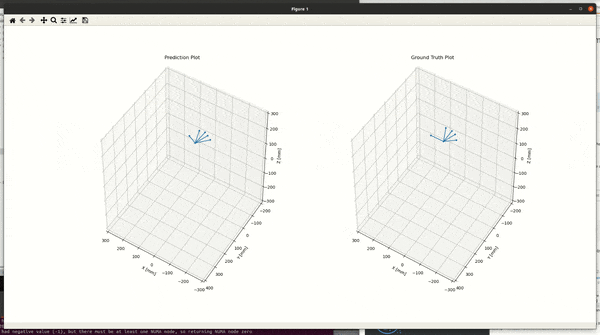



In this notebook, I will try to predict the position of the thumb from the palm. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Thumb data was gathered on April 7th, at 16:30 using [this](https://github.com/PerlinWarp/NeuroLeap/commit/09cba969eb64a9da1b9b925f458650e208ae997f) commit.

Important parts of this commit was that data was gathered using:
```
m = MyoRaw(raw=False, filtered=True) # 50Hz Filtered Myo data

	def get_points():
		frame = controller.frame()
		hand = frame.hands.rightmost
		if not hand.is_valid: return None
		fingers = hand.fingers

		X = []
		Y = []
		Z = []

		# Add the position of the palms
		X.append(-1 *hand.palm_position.x)
		Y.append(hand.palm_position.y)
		Z.append(hand.palm_position.z)

		for finger in fingers:
			# Add finger tip positions
			X.append(-1 * finger.stabilized_tip_position.x)
			Y.append(finger.stabilized_tip_position.y)
			Z.append(finger.stabilized_tip_position.z) 
		return np.array([X, Z, Y])

```

Note the **stabilized tip positions** from the [documentation](https://developer-archive.leapmotion.com/documentation/python/api/Leap.Pointable.html#Leap.Pointable.stabilized_tip_position):
  
Smoothing and stabilization is performed in order to make this value more suitable for interaction with 2D content. The stabilized position lags behind the tip position by a variable amount, depending primarily on the speed of movement.


In [2]:
data = pd.read_csv("thumb_dataset_30.csv")

In [3]:
data.head()

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Palm_tip_x,Thumb_tip_x,...,Index_tip_y,Middle_tip_y,Ring_tip_y,Pinky_tip_y,Palm_tip_z,Thumb_tip_z,Index_tip_z,Middle_tip_z,Ring_tip_z,Pinky_tip_z
0,31,140,140,83,42,30,22,21,-18.167004,27.724434,...,-73.758804,-89.471649,-79.439949,-71.918144,144.981094,120.059906,133.536011,124.068176,119.804108,109.158684
1,30,154,193,89,53,31,21,21,-18.131498,27.894018,...,-73.705612,-89.391991,-79.372650,-71.772514,144.968231,120.200348,133.561554,124.106369,119.839752,109.234200
2,31,159,193,89,57,33,27,28,-18.109987,28.061665,...,-73.654808,-89.311295,-79.303879,-71.628952,144.953217,120.337166,133.585297,124.143944,119.874626,109.307076
3,33,152,177,96,58,34,27,30,-18.092686,28.231144,...,-73.604759,-89.231735,-79.234291,-71.495186,144.924377,120.473526,133.607986,124.180008,119.908142,109.373688
4,30,134,182,88,56,34,29,30,-18.089689,28.402817,...,-73.555382,-89.153038,-79.166466,-71.375092,144.883591,120.609833,133.629761,124.214531,119.939423,109.432350


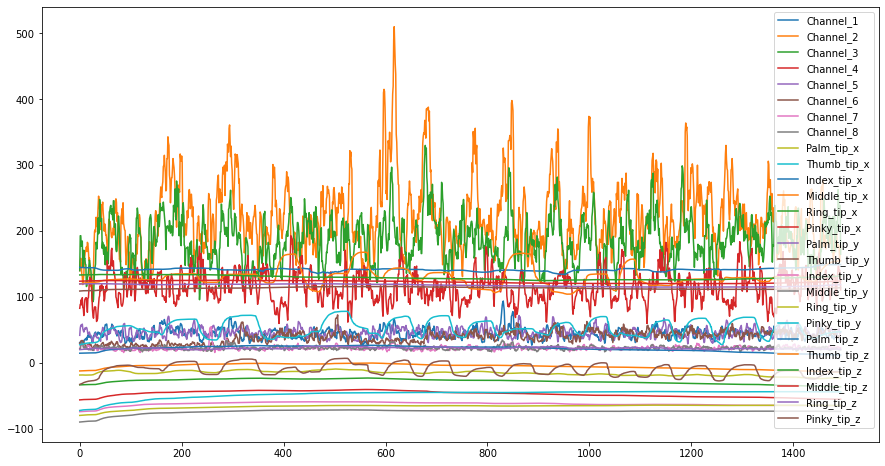

In [4]:
import matplotlib

matplotlib.rc('figure', figsize=(15, 8))

data.plot()

In [5]:
data.columns

Index(['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8', 'Palm_tip_x', 'Thumb_tip_x',
       'Index_tip_x', 'Middle_tip_x', 'Ring_tip_x', 'Pinky_tip_x',
       'Palm_tip_y', 'Thumb_tip_y', 'Index_tip_y', 'Middle_tip_y',
       'Ring_tip_y', 'Pinky_tip_y', 'Palm_tip_z', 'Thumb_tip_z', 'Index_tip_z',
       'Middle_tip_z', 'Ring_tip_z', 'Pinky_tip_z'],
      dtype='object')

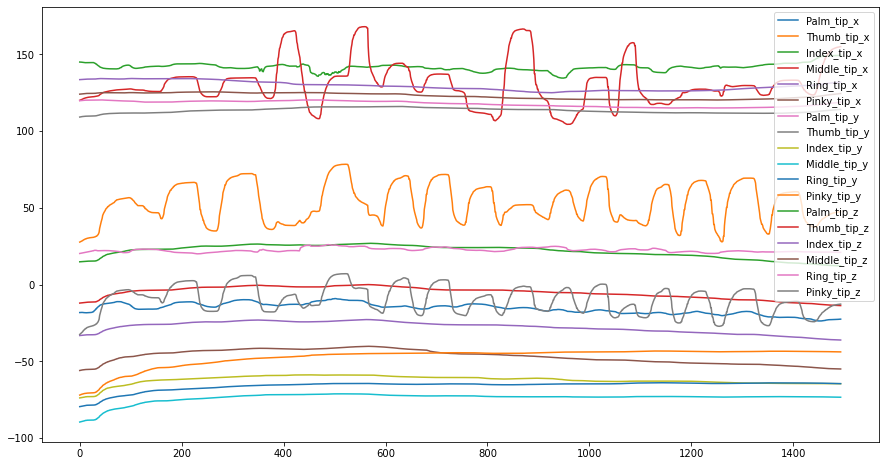

In [6]:
# Just considering the position data
pos_cols = ['Palm_tip_x', 'Thumb_tip_x',
       'Index_tip_x', 'Middle_tip_x', 'Ring_tip_x', 'Pinky_tip_x',
       'Palm_tip_y', 'Thumb_tip_y', 'Index_tip_y', 'Middle_tip_y',
       'Ring_tip_y', 'Pinky_tip_y', 'Palm_tip_z', 'Thumb_tip_z', 'Index_tip_z',
       'Middle_tip_z', 'Ring_tip_z', 'Pinky_tip_z']

df = data[pos_cols]
df.plot()

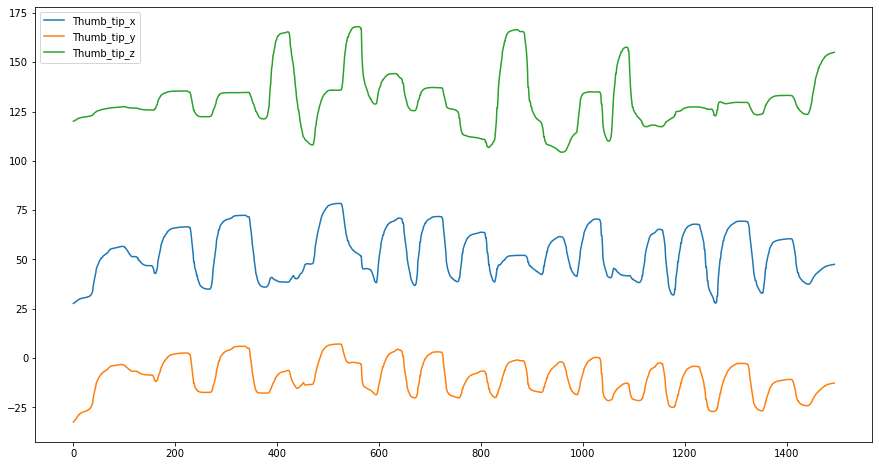

In [7]:
# Just considering the thumb
cols = ['Thumb_tip_x', 'Thumb_tip_y', 'Thumb_tip_z']
df = data[cols]
df.plot()

In [8]:
data.var()

Channel_1         61.155101
Channel_2       2981.336682
Channel_3       1252.896925
Channel_4        504.741145
Channel_5         47.501323
Channel_6         76.654646
Channel_7         10.194760
Channel_8          6.626612
Palm_tip_x        12.398094
Thumb_tip_x      155.309039
Index_tip_x       16.549957
Middle_tip_x      14.101624
Ring_tip_x        13.377871
Pinky_tip_x       19.356980
Palm_tip_y         1.829982
Thumb_tip_y       80.012689
Index_tip_y        7.472674
Middle_tip_y      10.030366
Ring_tip_y         9.116989
Pinky_tip_y       36.370002
Palm_tip_z         5.673768
Thumb_tip_z      197.256755
Index_tip_z        8.645685
Middle_tip_z       3.685747
Ring_tip_z         3.382069
Pinky_tip_z        2.506600
dtype: float64

By looking at the variance, we can make sure we didn't move the arm around too much.

In [9]:
data.columns

Index(['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8', 'Palm_tip_x', 'Thumb_tip_x',
       'Index_tip_x', 'Middle_tip_x', 'Ring_tip_x', 'Pinky_tip_x',
       'Palm_tip_y', 'Thumb_tip_y', 'Index_tip_y', 'Middle_tip_y',
       'Ring_tip_y', 'Pinky_tip_y', 'Palm_tip_z', 'Thumb_tip_z', 'Index_tip_z',
       'Middle_tip_z', 'Ring_tip_z', 'Pinky_tip_z'],
      dtype='object')

From now on, I will only use sEMG, thumb and palm data. The palm data is to use as a reference. 

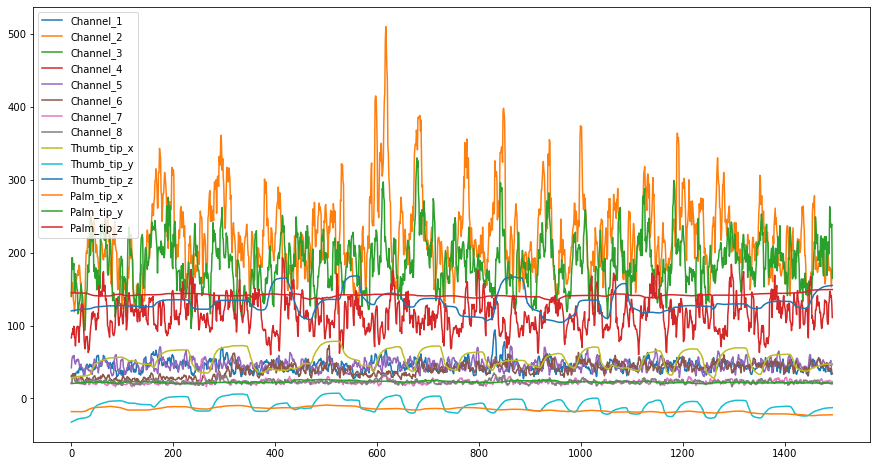

In [10]:
# Just considering the data we care about
cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8','Thumb_tip_x', 'Thumb_tip_y', 'Thumb_tip_z', 
       'Palm_tip_x', 'Palm_tip_y', 'Palm_tip_z']
df = data[cols]
df.plot()

[Text(0.5, 1.0, 'sEMG and Leap corrolations')]

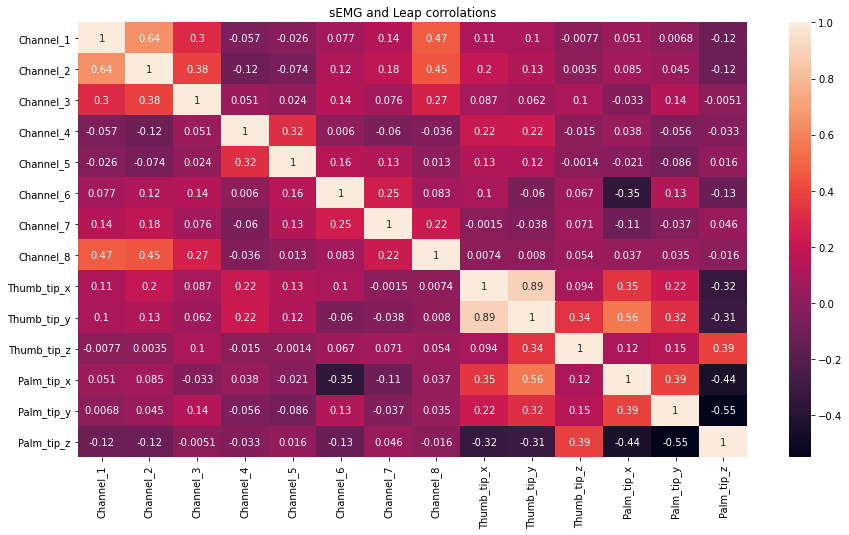

In [11]:
sns.heatmap(df.corr(), annot=True).set(title="sEMG and Leap corrolations")

# Feature engineering: relative positions

In [12]:
df.columns

Index(['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4', 'Channel_5',
       'Channel_6', 'Channel_7', 'Channel_8', 'Thumb_tip_x', 'Thumb_tip_y',
       'Thumb_tip_z', 'Palm_tip_x', 'Palm_tip_y', 'Palm_tip_z'],
      dtype='object')

<ipython-input-13-69a715ef4de4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel["Thumb_r_tip_x"] = df_rel["Thumb_tip_x"] - df_rel['Palm_tip_x']
<ipython-input-13-69a715ef4de4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel["Thumb_r_tip_y"] = df_rel["Thumb_tip_y"] - df_rel['Palm_tip_y']
<ipython-input-13-69a715ef4de4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

[Text(0.5, 1.0, 'sEMG and Leap rel corrolations')]

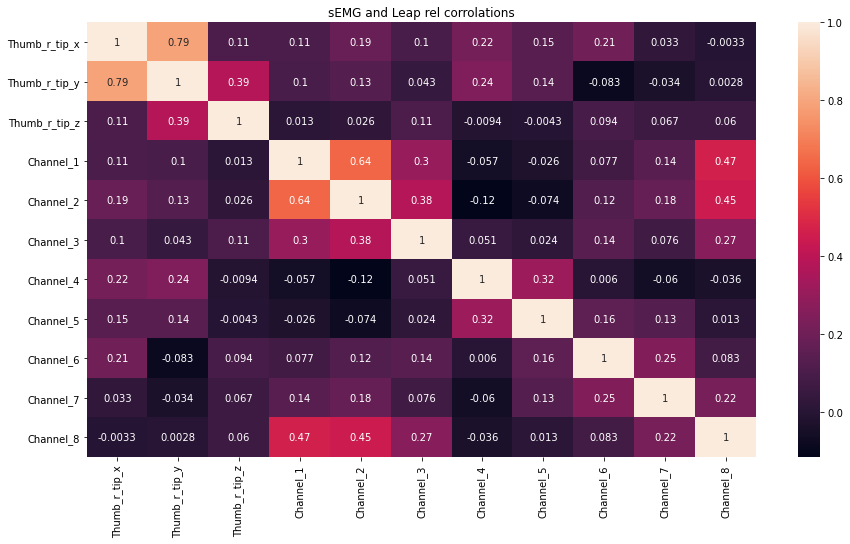

In [13]:
df_rel = df
df_rel["Thumb_r_tip_x"] = df_rel["Thumb_tip_x"] - df_rel['Palm_tip_x']
df_rel["Thumb_r_tip_y"] = df_rel["Thumb_tip_y"] - df_rel['Palm_tip_y']
df_rel["Thumb_r_tip_z"] = df_rel["Thumb_tip_z"] - df_rel['Palm_tip_z']

df_rel = df_rel[['Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z',
                 'Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
                 'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']]

sns.heatmap(df_rel.corr(), annot=True).set(title="sEMG and Leap rel corrolations")

[Text(0.5, 1.0, 'sEMG and Leap rel corrolations')]

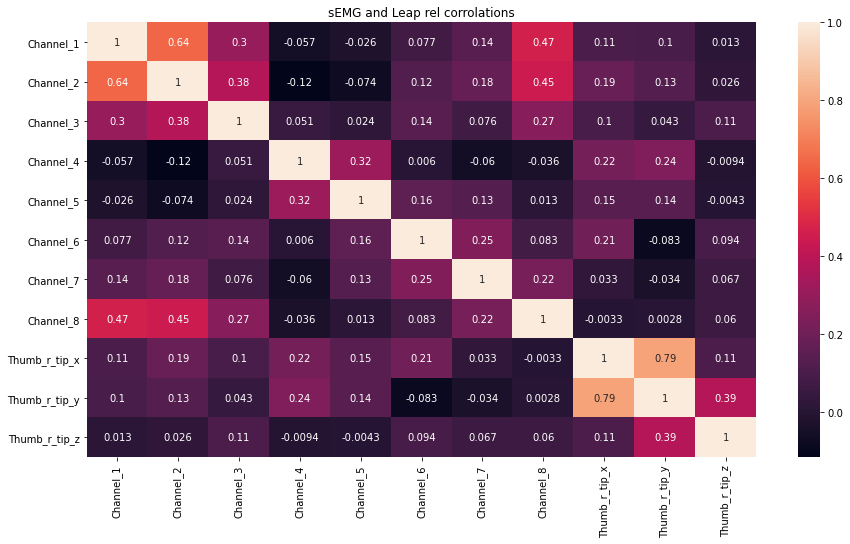

In [14]:
df_rel = df_rel[['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
                 'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8', 
                 'Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z']]

sns.heatmap(df_rel.corr(), annot=True).set(title="sEMG and Leap rel corrolations")

# Making some baseline ML

## Train Test Split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
y_cols = ['Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df_rel['Thumb_r_tip_x']
X = df_rel[x_cols]
train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

In [17]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error X: " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error X: 8.009601955107827


In [18]:
y_cols = ['Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df['Thumb_r_tip_x']
X = df[x_cols]
train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error Y: " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error Y: 8.220693674954502


In [19]:
y_cols = ['Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df['Thumb_r_tip_z']
X = df[x_cols]
train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=False)

predictions = my_model.predict(test_X)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error Z: " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error Z: 9.287700256482164


We can see that using the relative position does not make the model much better. 

# Multivariate regression

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [21]:
y_cols = ['Thumb_r_tip_x', 'Thumb_r_tip_y','Thumb_r_tip_z']
x_cols = ['Channel_1', 'Channel_2', 'Channel_3', 'Channel_4',
          'Channel_5', 'Channel_6', 'Channel_7', 'Channel_8']

y = df_rel[y_cols]
X = df_rel[x_cols]
train_X, test_X, train_y, test_y = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.25)

In [24]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(8, kernel_initializer='normal',input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(3, kernel_initializer='normal',activation='sigmoid'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 68,939
Trainable params: 68,939
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = NN_model.fit(train_X, train_y, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
28/28 [==============================] - 0s 7ms/step - loss: 38.4002 - mean_absolute_error: 38.4002 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 2/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 3/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 4/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 5/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 6/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.542

Epoch 50/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 51/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 52/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 53/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 54/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 55/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 

Epoch 99/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 100/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 101/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 102/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 103/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 104/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_er

28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 196/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 197/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 198/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 199/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 200/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425


28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 292/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 293/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 294/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 295/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 296/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425


28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 388/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 389/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 390/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 391/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 392/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425


28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 484/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 485/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 486/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 487/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425
Epoch 488/500
28/28 [==============================] - 0s 2ms/step - loss: 38.3700 - mean_absolute_error: 38.3700 - val_loss: 38.5425 - val_mean_absolute_error: 38.5425


In [35]:
# Evaluate the model on the test data
loss, mea = NN_model.evaluate(test_X, test_y)
mea

12/12 [==============================] - 0s 938us/step - loss: 38.2909 - mean_absolute_error: 38.2909


38.290855407714844

In [36]:
sample_input = np.array([ 59, 194, 176, 117,  41,  27,  23,  23]).reshape(1,8)
sample_input.shape
NN_model.predict(sample_input)

array([[1.0000000e+00, 2.9582267e-13, 2.1634388e-13]], dtype=float32)

We can see our model predicts 0. 

In [37]:
NN_model.save("BenchmarkNNRel.h5")

In [4]:
# Predict from the live data
from keras.models import load_model

model = load_model('BenchmarkNNRel.h5')
model.predict(sample_input)

NameError: name 'sample_input' is not defined

In [39]:
np.array([[ 51.149292 ,  -7.4921813, 127.01072  ]], dtype='float32')

array([[ 51.149292 ,  -7.4921813, 127.01072  ]], dtype=float32)

## Why does the neural network suck?

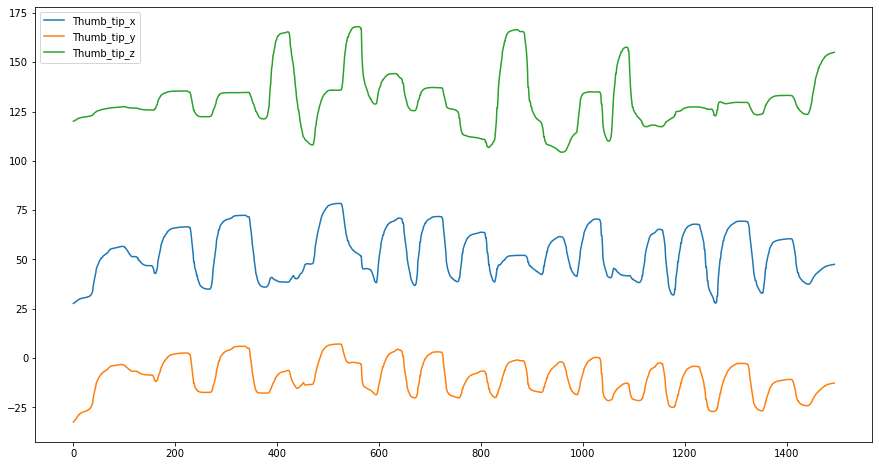

In [42]:
cols = ['Thumb_tip_x', 'Thumb_tip_y', 'Thumb_tip_z']
df = data[cols]
df.plot()

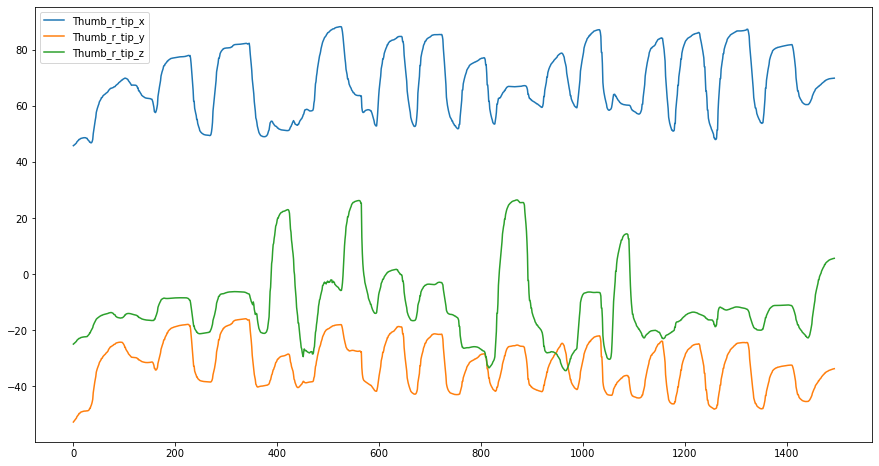

In [41]:
y.plot()

In [45]:
(df['Thumb_tip_z'] - df['Thumb_tip_y']).mean()

140.60280984070855

In [47]:
(y['Thumb_r_tip_x'] - y['Thumb_r_tip_y']).mean()

100.9797653352126

## Data preprocessing

In [30]:
from sklearn.preprocessing import MinMaxScaler

rel_hand_scaler = MinMaxScaler()
emg_scaler = MinMaxScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

train_X, test_X, train_y, test_y = train_test_split(nX, ny, test_size=0.25)

In [59]:
history = NN_model.fit(train_X, train_y, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
28/28 [==============================] - 0s 3ms/step - loss: 0.1804 - mean_absolute_error: 0.1804 - val_loss: 0.1796 - val_mean_absolute_error: 0.1796
Epoch 2/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1813 - mean_absolute_error: 0.1813 - val_loss: 0.1800 - val_mean_absolute_error: 0.1800
Epoch 3/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1794 - mean_absolute_error: 0.1794 - val_loss: 0.1802 - val_mean_absolute_error: 0.1802
Epoch 4/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1797 - mean_absolute_error: 0.1797 - val_loss: 0.1794 - val_mean_absolute_error: 0.1794
Epoch 5/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1788 - mean_absolute_error: 0.1788 - val_loss: 0.1794 - val_mean_absolute_error: 0.1794
Epoch 6/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1785 - mean_absolute_error: 0.1785 - val_loss: 0.1797 - val_mean_absolute_error: 0.1797
Epoch 7/500
28/28 [===

28/28 [==============================] - 0s 2ms/step - loss: 0.1771 - mean_absolute_error: 0.1771 - val_loss: 0.1795 - val_mean_absolute_error: 0.1795
Epoch 52/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1779 - mean_absolute_error: 0.1779 - val_loss: 0.1802 - val_mean_absolute_error: 0.1802
Epoch 53/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1778 - mean_absolute_error: 0.1778 - val_loss: 0.1794 - val_mean_absolute_error: 0.1794
Epoch 54/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1771 - mean_absolute_error: 0.1771 - val_loss: 0.1798 - val_mean_absolute_error: 0.1798
Epoch 55/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1767 - mean_absolute_error: 0.1767 - val_loss: 0.1805 - val_mean_absolute_error: 0.1805
Epoch 56/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1778 - mean_absolute_error: 0.1778 - val_loss: 0.1807 - val_mean_absolute_error: 0.1807
Epoch 57/500
28/28 [=========

28/28 [==============================] - 0s 2ms/step - loss: 0.1764 - mean_absolute_error: 0.1764 - val_loss: 0.1812 - val_mean_absolute_error: 0.1812
Epoch 102/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1804 - val_mean_absolute_error: 0.1804
Epoch 103/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1760 - mean_absolute_error: 0.1760 - val_loss: 0.1804 - val_mean_absolute_error: 0.1804
Epoch 104/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1762 - mean_absolute_error: 0.1762 - val_loss: 0.1800 - val_mean_absolute_error: 0.1800
Epoch 105/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1761 - mean_absolute_error: 0.1761 - val_loss: 0.1800 - val_mean_absolute_error: 0.1800
Epoch 106/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1764 - mean_absolute_error: 0.1764 - val_loss: 0.1798 - val_mean_absolute_error: 0.1798
Epoch 107/500
28/28 [===

Epoch 151/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1755 - mean_absolute_error: 0.1755 - val_loss: 0.1801 - val_mean_absolute_error: 0.1801
Epoch 152/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1752 - mean_absolute_error: 0.1752 - val_loss: 0.1811 - val_mean_absolute_error: 0.1811
Epoch 153/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1752 - mean_absolute_error: 0.1752 - val_loss: 0.1819 - val_mean_absolute_error: 0.1819
Epoch 154/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1747 - mean_absolute_error: 0.1747 - val_loss: 0.1805 - val_mean_absolute_error: 0.1805
Epoch 155/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1752 - mean_absolute_error: 0.1752 - val_loss: 0.1805 - val_mean_absolute_error: 0.1805
Epoch 156/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1752 - mean_absolute_error: 0.1752 - val_loss: 0.1811 - val_mean_absolute_error: 0.1811
Epoch 157/

Epoch 201/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1755 - mean_absolute_error: 0.1755 - val_loss: 0.1797 - val_mean_absolute_error: 0.1797
Epoch 202/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1742 - mean_absolute_error: 0.1742 - val_loss: 0.1810 - val_mean_absolute_error: 0.1810
Epoch 203/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1746 - mean_absolute_error: 0.1746 - val_loss: 0.1806 - val_mean_absolute_error: 0.1806
Epoch 204/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1748 - mean_absolute_error: 0.1748 - val_loss: 0.1814 - val_mean_absolute_error: 0.1814
Epoch 205/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1751 - mean_absolute_error: 0.1751 - val_loss: 0.1807 - val_mean_absolute_error: 0.1807
Epoch 206/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1751 - mean_absolute_error: 0.1751 - val_loss: 0.1825 - val_mean_absolute_error: 0.1825
Epoch 207/

Epoch 251/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1743 - mean_absolute_error: 0.1743 - val_loss: 0.1810 - val_mean_absolute_error: 0.1810
Epoch 252/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1740 - mean_absolute_error: 0.1740 - val_loss: 0.1810 - val_mean_absolute_error: 0.1810
Epoch 253/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1739 - mean_absolute_error: 0.1739 - val_loss: 0.1822 - val_mean_absolute_error: 0.1822
Epoch 254/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1746 - mean_absolute_error: 0.1746 - val_loss: 0.1811 - val_mean_absolute_error: 0.1811
Epoch 255/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1739 - mean_absolute_error: 0.1739 - val_loss: 0.1807 - val_mean_absolute_error: 0.1807
Epoch 256/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1739 - mean_absolute_error: 0.1739 - val_loss: 0.1798 - val_mean_absolute_error: 0.1798
Epoch 257/

Epoch 301/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1741 - mean_absolute_error: 0.1741 - val_loss: 0.1833 - val_mean_absolute_error: 0.1833
Epoch 302/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1733 - mean_absolute_error: 0.1733 - val_loss: 0.1808 - val_mean_absolute_error: 0.1808
Epoch 303/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1740 - mean_absolute_error: 0.1740 - val_loss: 0.1823 - val_mean_absolute_error: 0.1823
Epoch 304/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1733 - mean_absolute_error: 0.1733 - val_loss: 0.1818 - val_mean_absolute_error: 0.1818
Epoch 305/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1738 - mean_absolute_error: 0.1738 - val_loss: 0.1812 - val_mean_absolute_error: 0.1812
Epoch 306/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1738 - mean_absolute_error: 0.1738 - val_loss: 0.1813 - val_mean_absolute_error: 0.1813
Epoch 307/

Epoch 351/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1731 - mean_absolute_error: 0.1731 - val_loss: 0.1817 - val_mean_absolute_error: 0.1817
Epoch 352/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1724 - mean_absolute_error: 0.1724 - val_loss: 0.1801 - val_mean_absolute_error: 0.1801
Epoch 353/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1735 - mean_absolute_error: 0.1735 - val_loss: 0.1819 - val_mean_absolute_error: 0.1819
Epoch 354/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1729 - mean_absolute_error: 0.1729 - val_loss: 0.1818 - val_mean_absolute_error: 0.1818
Epoch 355/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1729 - mean_absolute_error: 0.1729 - val_loss: 0.1825 - val_mean_absolute_error: 0.1825
Epoch 356/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1732 - mean_absolute_error: 0.1732 - val_loss: 0.1801 - val_mean_absolute_error: 0.1801
Epoch 357/

Epoch 401/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1727 - mean_absolute_error: 0.1727 - val_loss: 0.1821 - val_mean_absolute_error: 0.1821
Epoch 402/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1729 - mean_absolute_error: 0.1729 - val_loss: 0.1813 - val_mean_absolute_error: 0.1813
Epoch 403/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1721 - mean_absolute_error: 0.1721 - val_loss: 0.1845 - val_mean_absolute_error: 0.1845
Epoch 404/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1722 - mean_absolute_error: 0.1722 - val_loss: 0.1826 - val_mean_absolute_error: 0.1826
Epoch 405/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1726 - mean_absolute_error: 0.1726 - val_loss: 0.1821 - val_mean_absolute_error: 0.1821
Epoch 406/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1728 - mean_absolute_error: 0.1728 - val_loss: 0.1836 - val_mean_absolute_error: 0.1836
Epoch 407/

Epoch 451/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1720 - mean_absolute_error: 0.1720 - val_loss: 0.1824 - val_mean_absolute_error: 0.1824
Epoch 452/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1714 - mean_absolute_error: 0.1714 - val_loss: 0.1854 - val_mean_absolute_error: 0.1854
Epoch 453/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1718 - mean_absolute_error: 0.1718 - val_loss: 0.1828 - val_mean_absolute_error: 0.1828
Epoch 454/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1712 - mean_absolute_error: 0.1712 - val_loss: 0.1835 - val_mean_absolute_error: 0.1835
Epoch 455/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1722 - mean_absolute_error: 0.1722 - val_loss: 0.1830 - val_mean_absolute_error: 0.1830
Epoch 456/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1722 - mean_absolute_error: 0.1722 - val_loss: 0.1850 - val_mean_absolute_error: 0.1850
Epoch 457/

By minmax scaling our input, the model mean absolute error went from 38 to 0.1756. 

In [60]:
NN_model.save("../models/BenchmarkNNRel-MinMaxScaled.h5")

However now we have saved out model, we want to be able to save our scaler too.
https://stackoverflow.com/questions/41993565/save-minmaxscaler-model-in-sklearn


In [61]:
import joblib
# Save hand scaler to file.
# Scales the output of the network, the relative position of the hand, min_max
joblib.dump(rel_hand_scaler, '../models/MinMaxRelThumb8Apr-Hand.gz')

# Scales the input to the network, the emg data. 
joblib.dump(emg_scaler, '../models/MinMaxRelThumb8Apr-EMG.gz')

my_scaler = joblib.load('../models/MinMaxRelThumb8Apr.gz')

In [73]:
X.head(1).to_numpy()

array([[ 31, 140, 140,  83,  42,  30,  22,  21]])

In [6]:
# Making a prediction in the prediction script. 
model = load_model('../models/BenchmarkNNRel-MinMaxScaled.h5')

input_scaler = joblib.load('../models/MinMaxRelThumb8Apr-EMG.gz')
output_scaler = joblib.load('../models/MinMaxRelThumb8Apr-Hand.gz')

# Get some input data
semg_input = np.array([[ 31, 140, 140,  83,  42,  30,  22,  21]])
# Scale the input
scaled_input = input_scaler.transform(semg_input)
# Get a prediction
pred = model.predict(scaled_input)
# Scale it back to a value
scaled_pred = output_scaler.inverse_transform(pred)
scaled_pred

array([[ 59.41619 , -40.734028, -18.90253 ]], dtype=float32)

# So what does this model look like?

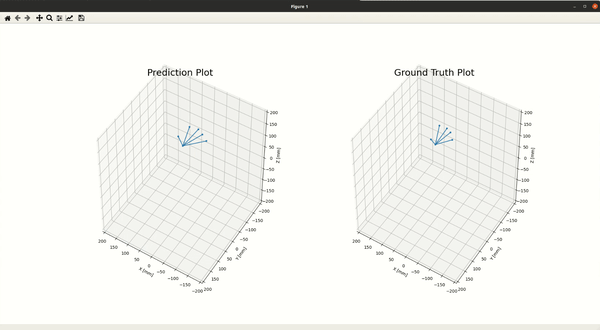

We can see it is a more stable model, and is no longer predicting the thumb to be far longer than it is, which is an improvement, however it is clear further work is needed...

## Trying alternate scaling

In [27]:
from sklearn.preprocessing import StandardScaler

rel_hand_scaler = StandardScaler()
emg_scaler = StandardScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

train_X, test_X, train_y, test_y = train_test_split(nX, ny, test_size=0.25)

In [28]:
history = NN_model.fit(train_X, train_y, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7510 - mean_absolute_error: 0.7510 - val_loss: 0.7556 - val_mean_absolute_error: 0.7556
Epoch 2/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7485 - mean_absolute_error: 0.7485 - val_loss: 0.7517 - val_mean_absolute_error: 0.7517
Epoch 3/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7470 - mean_absolute_error: 0.7470 - val_loss: 0.7533 - val_mean_absolute_error: 0.7533
Epoch 4/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7473 - mean_absolute_error: 0.7473 - val_loss: 0.7514 - val_mean_absolute_error: 0.7514
Epoch 5/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7470 - mean_absolute_error: 0.7470 - val_loss: 0.7547 - val_mean_absolute_error: 0.7547
Epoch 6/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7454 - mean_absolute_error: 0.7454 - val_loss: 0.7573 - val_mean_absolute_error: 0.7573
Epoch 7/500
28/28 [===

28/28 [==============================] - 0s 2ms/step - loss: 0.7327 - mean_absolute_error: 0.7327 - val_loss: 0.7583 - val_mean_absolute_error: 0.7583
Epoch 52/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7339 - mean_absolute_error: 0.7339 - val_loss: 0.7623 - val_mean_absolute_error: 0.7623
Epoch 53/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7328 - mean_absolute_error: 0.7328 - val_loss: 0.7590 - val_mean_absolute_error: 0.7590
Epoch 54/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7319 - mean_absolute_error: 0.7319 - val_loss: 0.7619 - val_mean_absolute_error: 0.7619
Epoch 55/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7324 - mean_absolute_error: 0.7324 - val_loss: 0.7621 - val_mean_absolute_error: 0.7621
Epoch 56/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7316 - mean_absolute_error: 0.7316 - val_loss: 0.7610 - val_mean_absolute_error: 0.7610
Epoch 57/500
28/28 [=========

28/28 [==============================] - 0s 2ms/step - loss: 0.7294 - mean_absolute_error: 0.7294 - val_loss: 0.7661 - val_mean_absolute_error: 0.7661
Epoch 102/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7289 - mean_absolute_error: 0.7289 - val_loss: 0.7635 - val_mean_absolute_error: 0.7635
Epoch 103/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7283 - mean_absolute_error: 0.7283 - val_loss: 0.7669 - val_mean_absolute_error: 0.7669
Epoch 104/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7279 - mean_absolute_error: 0.7279 - val_loss: 0.7644 - val_mean_absolute_error: 0.7644
Epoch 105/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7269 - mean_absolute_error: 0.7269 - val_loss: 0.7665 - val_mean_absolute_error: 0.7665
Epoch 106/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7265 - mean_absolute_error: 0.7265 - val_loss: 0.7658 - val_mean_absolute_error: 0.7658
Epoch 107/500
28/28 [===

Epoch 151/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7237 - mean_absolute_error: 0.7237 - val_loss: 0.7717 - val_mean_absolute_error: 0.7717
Epoch 152/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7238 - mean_absolute_error: 0.7238 - val_loss: 0.7741 - val_mean_absolute_error: 0.7741
Epoch 153/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7235 - mean_absolute_error: 0.7235 - val_loss: 0.7707 - val_mean_absolute_error: 0.7707
Epoch 154/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7228 - mean_absolute_error: 0.7228 - val_loss: 0.7694 - val_mean_absolute_error: 0.7694
Epoch 155/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7239 - mean_absolute_error: 0.7239 - val_loss: 0.7698 - val_mean_absolute_error: 0.7698
Epoch 156/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7232 - mean_absolute_error: 0.7232 - val_loss: 0.7669 - val_mean_absolute_error: 0.7669
Epoch 157/

Epoch 201/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7197 - mean_absolute_error: 0.7197 - val_loss: 0.7737 - val_mean_absolute_error: 0.7737
Epoch 202/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7207 - mean_absolute_error: 0.7207 - val_loss: 0.7761 - val_mean_absolute_error: 0.7761
Epoch 203/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7193 - mean_absolute_error: 0.7193 - val_loss: 0.7771 - val_mean_absolute_error: 0.7771
Epoch 204/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7195 - mean_absolute_error: 0.7195 - val_loss: 0.7746 - val_mean_absolute_error: 0.7746
Epoch 205/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7193 - mean_absolute_error: 0.7193 - val_loss: 0.7746 - val_mean_absolute_error: 0.7746
Epoch 206/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7200 - mean_absolute_error: 0.7200 - val_loss: 0.7741 - val_mean_absolute_error: 0.7741
Epoch 207/

Epoch 251/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7171 - mean_absolute_error: 0.7171 - val_loss: 0.7779 - val_mean_absolute_error: 0.7779
Epoch 252/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7158 - mean_absolute_error: 0.7158 - val_loss: 0.7762 - val_mean_absolute_error: 0.7762
Epoch 253/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7158 - mean_absolute_error: 0.7158 - val_loss: 0.7766 - val_mean_absolute_error: 0.7766
Epoch 254/500
28/28 [==============================] - 0s 1ms/step - loss: 0.7165 - mean_absolute_error: 0.7165 - val_loss: 0.7748 - val_mean_absolute_error: 0.7748
Epoch 255/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7164 - mean_absolute_error: 0.7164 - val_loss: 0.7774 - val_mean_absolute_error: 0.7774
Epoch 256/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7163 - mean_absolute_error: 0.7163 - val_loss: 0.7758 - val_mean_absolute_error: 0.7758
Epoch 257/

Epoch 301/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7121 - mean_absolute_error: 0.7121 - val_loss: 0.7804 - val_mean_absolute_error: 0.7804
Epoch 302/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7144 - mean_absolute_error: 0.7144 - val_loss: 0.7741 - val_mean_absolute_error: 0.7741
Epoch 303/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7139 - mean_absolute_error: 0.7139 - val_loss: 0.7766 - val_mean_absolute_error: 0.7766
Epoch 304/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7089 - mean_absolute_error: 0.7089 - val_loss: 0.7752 - val_mean_absolute_error: 0.7752
Epoch 305/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7099 - mean_absolute_error: 0.7099 - val_loss: 0.7759 - val_mean_absolute_error: 0.7759
Epoch 306/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7095 - mean_absolute_error: 0.7095 - val_loss: 0.7771 - val_mean_absolute_error: 0.7771
Epoch 307/

Epoch 351/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7053 - mean_absolute_error: 0.7053 - val_loss: 0.7791 - val_mean_absolute_error: 0.7791
Epoch 352/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7070 - mean_absolute_error: 0.7070 - val_loss: 0.7774 - val_mean_absolute_error: 0.7774
Epoch 353/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7069 - mean_absolute_error: 0.7069 - val_loss: 0.7817 - val_mean_absolute_error: 0.7817
Epoch 354/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7062 - mean_absolute_error: 0.7062 - val_loss: 0.7790 - val_mean_absolute_error: 0.7790
Epoch 355/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7059 - mean_absolute_error: 0.7059 - val_loss: 0.7730 - val_mean_absolute_error: 0.7730
Epoch 356/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7065 - mean_absolute_error: 0.7065 - val_loss: 0.7778 - val_mean_absolute_error: 0.7778
Epoch 357/

Epoch 401/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7030 - mean_absolute_error: 0.7030 - val_loss: 0.7768 - val_mean_absolute_error: 0.7768
Epoch 402/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7024 - mean_absolute_error: 0.7024 - val_loss: 0.7786 - val_mean_absolute_error: 0.7786
Epoch 403/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7022 - mean_absolute_error: 0.7022 - val_loss: 0.7755 - val_mean_absolute_error: 0.7755
Epoch 404/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7030 - mean_absolute_error: 0.7030 - val_loss: 0.7791 - val_mean_absolute_error: 0.7791
Epoch 405/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7028 - mean_absolute_error: 0.7028 - val_loss: 0.7779 - val_mean_absolute_error: 0.7779
Epoch 406/500
28/28 [==============================] - 0s 2ms/step - loss: 0.7042 - mean_absolute_error: 0.7042 - val_loss: 0.7772 - val_mean_absolute_error: 0.7772
Epoch 407/

Epoch 451/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6992 - mean_absolute_error: 0.6992 - val_loss: 0.7761 - val_mean_absolute_error: 0.7761
Epoch 452/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6986 - mean_absolute_error: 0.6986 - val_loss: 0.7752 - val_mean_absolute_error: 0.7752
Epoch 453/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6979 - mean_absolute_error: 0.6979 - val_loss: 0.7799 - val_mean_absolute_error: 0.7799
Epoch 454/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6992 - mean_absolute_error: 0.6992 - val_loss: 0.7767 - val_mean_absolute_error: 0.7767
Epoch 455/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6986 - mean_absolute_error: 0.6986 - val_loss: 0.7751 - val_mean_absolute_error: 0.7751
Epoch 456/500
28/28 [==============================] - 0s 2ms/step - loss: 0.6996 - mean_absolute_error: 0.6996 - val_loss: 0.7771 - val_mean_absolute_error: 0.7771
Epoch 457/

## Trying alternate architectures.

In [31]:
rel_hand_scaler = MinMaxScaler()
emg_scaler = MinMaxScaler()

ny = rel_hand_scaler.fit_transform(y)
nX = emg_scaler.fit_transform(X)

train_X, test_X, train_y, test_y = train_test_split(nX, ny, test_size=0.25)

In [32]:
model = Sequential()

# The Input Layer :
model.add(Dense(256, kernel_initializer='normal',input_dim = train_X.shape[1], activation='relu'))

# The Hidden Layers :
model.add(Dense(256, kernel_initializer='normal',activation='relu'))
model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
model.add(Dense(3, kernel_initializer='normal',activation='sigmoid'))

# Compile the network :
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2304      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
Total params: 134,659
Trainable params: 134,659
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(train_X, train_y, epochs=500, batch_size=32, validation_split = 0.2)

Epoch 1/500
28/28 [==============================] - 0s 7ms/step - loss: 0.2045 - mean_absolute_error: 0.2045 - val_loss: 0.1950 - val_mean_absolute_error: 0.1950
Epoch 2/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1998 - mean_absolute_error: 0.1998 - val_loss: 0.1930 - val_mean_absolute_error: 0.1930
Epoch 3/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1992 - mean_absolute_error: 0.1992 - val_loss: 0.1951 - val_mean_absolute_error: 0.1951
Epoch 4/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1948 - mean_absolute_error: 0.1948 - val_loss: 0.1898 - val_mean_absolute_error: 0.1898
Epoch 5/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1905 - mean_absolute_error: 0.1905 - val_loss: 0.1847 - val_mean_absolute_error: 0.1847
Epoch 6/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1866 - mean_absolute_error: 0.1866 - val_loss: 0.1843 - val_mean_absolute_error: 0.1843
Epoch 7/500
28/28 [===

28/28 [==============================] - 0s 2ms/step - loss: 0.1456 - mean_absolute_error: 0.1456 - val_loss: 0.1657 - val_mean_absolute_error: 0.1657
Epoch 52/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1434 - mean_absolute_error: 0.1434 - val_loss: 0.1674 - val_mean_absolute_error: 0.1674
Epoch 53/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1425 - mean_absolute_error: 0.1425 - val_loss: 0.1648 - val_mean_absolute_error: 0.1648
Epoch 54/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1415 - mean_absolute_error: 0.1415 - val_loss: 0.1652 - val_mean_absolute_error: 0.1652
Epoch 55/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1417 - mean_absolute_error: 0.1417 - val_loss: 0.1679 - val_mean_absolute_error: 0.1679
Epoch 56/500
28/28 [==============================] - 0s 2ms/step - loss: 0.1453 - mean_absolute_error: 0.1453 - val_loss: 0.1629 - val_mean_absolute_error: 0.1629
Epoch 57/500
28/28 [=========

28/28 [==============================] - 0s 2ms/step - loss: 0.0984 - mean_absolute_error: 0.0984 - val_loss: 0.1547 - val_mean_absolute_error: 0.1547
Epoch 102/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0993 - mean_absolute_error: 0.0993 - val_loss: 0.1552 - val_mean_absolute_error: 0.1552
Epoch 103/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0963 - mean_absolute_error: 0.0963 - val_loss: 0.1574 - val_mean_absolute_error: 0.1574
Epoch 104/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0967 - mean_absolute_error: 0.0967 - val_loss: 0.1593 - val_mean_absolute_error: 0.1593
Epoch 105/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0956 - mean_absolute_error: 0.0956 - val_loss: 0.1576 - val_mean_absolute_error: 0.1576
Epoch 106/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0977 - mean_absolute_error: 0.0977 - val_loss: 0.1706 - val_mean_absolute_error: 0.1706
Epoch 107/500
28/28 [===

Epoch 151/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0736 - mean_absolute_error: 0.0736 - val_loss: 0.1579 - val_mean_absolute_error: 0.1579
Epoch 152/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0716 - mean_absolute_error: 0.0716 - val_loss: 0.1538 - val_mean_absolute_error: 0.1538
Epoch 153/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0692 - mean_absolute_error: 0.0692 - val_loss: 0.1539 - val_mean_absolute_error: 0.1539
Epoch 154/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0720 - mean_absolute_error: 0.0720 - val_loss: 0.1508 - val_mean_absolute_error: 0.1508
Epoch 155/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0761 - mean_absolute_error: 0.0761 - val_loss: 0.1584 - val_mean_absolute_error: 0.1584
Epoch 156/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0746 - mean_absolute_error: 0.0746 - val_loss: 0.1558 - val_mean_absolute_error: 0.1558
Epoch 157/

Epoch 201/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0539 - mean_absolute_error: 0.0539 - val_loss: 0.1531 - val_mean_absolute_error: 0.1531
Epoch 202/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0550 - mean_absolute_error: 0.0550 - val_loss: 0.1528 - val_mean_absolute_error: 0.1528
Epoch 203/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0558 - mean_absolute_error: 0.0558 - val_loss: 0.1530 - val_mean_absolute_error: 0.1530
Epoch 204/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0556 - mean_absolute_error: 0.0556 - val_loss: 0.1589 - val_mean_absolute_error: 0.1589
Epoch 205/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0551 - mean_absolute_error: 0.0551 - val_loss: 0.1544 - val_mean_absolute_error: 0.1544
Epoch 206/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0520 - mean_absolute_error: 0.0520 - val_loss: 0.1533 - val_mean_absolute_error: 0.1533
Epoch 207/

Epoch 251/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0435 - mean_absolute_error: 0.0435 - val_loss: 0.1541 - val_mean_absolute_error: 0.1541
Epoch 252/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0419 - mean_absolute_error: 0.0419 - val_loss: 0.1536 - val_mean_absolute_error: 0.1536
Epoch 253/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0452 - mean_absolute_error: 0.0452 - val_loss: 0.1520 - val_mean_absolute_error: 0.1520
Epoch 254/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0452 - mean_absolute_error: 0.0452 - val_loss: 0.1547 - val_mean_absolute_error: 0.1547
Epoch 255/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0452 - mean_absolute_error: 0.0452 - val_loss: 0.1522 - val_mean_absolute_error: 0.1522
Epoch 256/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0411 - mean_absolute_error: 0.0411 - val_loss: 0.1533 - val_mean_absolute_error: 0.1533
Epoch 257/

Epoch 301/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0337 - mean_absolute_error: 0.0337 - val_loss: 0.1500 - val_mean_absolute_error: 0.1500
Epoch 302/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0339 - mean_absolute_error: 0.0339 - val_loss: 0.1509 - val_mean_absolute_error: 0.1509
Epoch 303/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0355 - mean_absolute_error: 0.0355 - val_loss: 0.1524 - val_mean_absolute_error: 0.1524
Epoch 304/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0357 - mean_absolute_error: 0.0357 - val_loss: 0.1517 - val_mean_absolute_error: 0.1517
Epoch 305/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0349 - mean_absolute_error: 0.0349 - val_loss: 0.1533 - val_mean_absolute_error: 0.1533
Epoch 306/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - val_loss: 0.1559 - val_mean_absolute_error: 0.1559
Epoch 307/

Epoch 351/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0328 - mean_absolute_error: 0.0328 - val_loss: 0.1534 - val_mean_absolute_error: 0.1534
Epoch 352/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0320 - mean_absolute_error: 0.0320 - val_loss: 0.1517 - val_mean_absolute_error: 0.1517
Epoch 353/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0317 - mean_absolute_error: 0.0317 - val_loss: 0.1550 - val_mean_absolute_error: 0.1550
Epoch 354/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0309 - mean_absolute_error: 0.0309 - val_loss: 0.1515 - val_mean_absolute_error: 0.1515
Epoch 355/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.1522 - val_mean_absolute_error: 0.1522
Epoch 356/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0297 - mean_absolute_error: 0.0297 - val_loss: 0.1516 - val_mean_absolute_error: 0.1516
Epoch 357/

Epoch 401/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0276 - mean_absolute_error: 0.0276 - val_loss: 0.1508 - val_mean_absolute_error: 0.1508
Epoch 402/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0276 - mean_absolute_error: 0.0276 - val_loss: 0.1524 - val_mean_absolute_error: 0.1524
Epoch 403/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0263 - mean_absolute_error: 0.0263 - val_loss: 0.1562 - val_mean_absolute_error: 0.1562
Epoch 404/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0278 - mean_absolute_error: 0.0278 - val_loss: 0.1534 - val_mean_absolute_error: 0.1534
Epoch 405/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0261 - mean_absolute_error: 0.0261 - val_loss: 0.1512 - val_mean_absolute_error: 0.1512
Epoch 406/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0282 - mean_absolute_error: 0.0282 - val_loss: 0.1527 - val_mean_absolute_error: 0.1527
Epoch 407/

Epoch 451/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0228 - mean_absolute_error: 0.0228 - val_loss: 0.1533 - val_mean_absolute_error: 0.1533
Epoch 452/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0238 - mean_absolute_error: 0.0238 - val_loss: 0.1526 - val_mean_absolute_error: 0.1526
Epoch 453/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0253 - mean_absolute_error: 0.0253 - val_loss: 0.1533 - val_mean_absolute_error: 0.1533
Epoch 454/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0269 - mean_absolute_error: 0.0269 - val_loss: 0.1507 - val_mean_absolute_error: 0.1507
Epoch 455/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0242 - mean_absolute_error: 0.0242 - val_loss: 0.1531 - val_mean_absolute_error: 0.1531
Epoch 456/500
28/28 [==============================] - 0s 2ms/step - loss: 0.0240 - mean_absolute_error: 0.0240 - val_loss: 0.1527 - val_mean_absolute_error: 0.1527
Epoch 457/

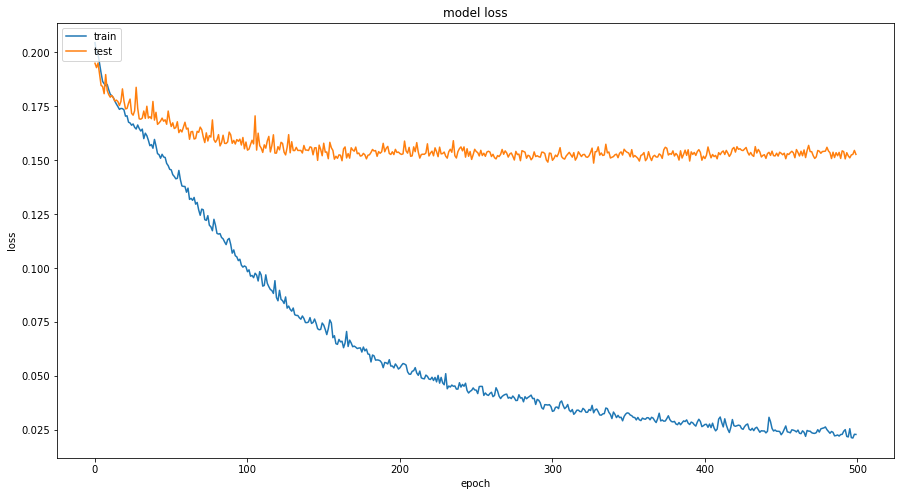

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
df_rel.shape

(1494, 11)

Given that df_rel is only 1,494 rows of data it is not worth trying to make a better model using it. 
A bigger problem I feel, is that when using animate_saved.py it is clear this dataset is not well representative of different thumb movements. 

Therefore I will make a better, more representitive dataset. 